In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [2]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv>
    <h4>MENU</h4><br>
    <a href=#Species_Richness>1. Species Richness</a><br>
    <a href=#Simpsons_Diversity>2. Simpson's Diversity</a><br>
    <a href=#Shannons_Diversity>3. Shannon's Diversity</a><br>
    <a href=#Evenness>4. Evenness</a><br><br>

    <a href=#Top>Top</a><br>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
    <a href=#LeftOff>Left Off Here</a><br>
    
    <h4>PROJECT NOTEBOOKS</h4><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Project_Overview'>Project Overview</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Data_Coverage'>Data Coverage</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/General_Results'>General Results</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Global_Estimate'>Global Estimates</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Crop_Diversity'>Crop Diversity</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Sensitivity_Analyses'>Sensitivity Analyses</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/'>Site Index</a><br>
</div>
''')

<a name="Top"></a>
<center><h1>Crop Diversity by Farm Size</h1>


This section explores the relationship between farm size and crop diversity in our dataset. The hypothesis tested is that smaller farms have greater crop diversity, while larger farms specialize in a smaller number of crop species. Since our dataset is at the species level, a major caveat to these findings is that varietal diversity cannot be examined.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import subprocess
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib import colors
import copy
from collections import OrderedDict
from pivottablejs import pivot_ui  # may have to use: python setup.py install --user
import scipy.stats as st
import statsmodels.stats.api as sms
from scipy.stats import linregress
import matplotlib.patches as patches
from sklearn import linear_model
# import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import itertools

plt.style.use('seaborn-muted')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [2]:
def read_data_init(path):
    
    data = pd.read_csv(path, low_memory=False)
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 1, 2, 5, 10, 20, 50,
                                      100, 200, 500, 1000, 100000])
    
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    return data

PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
data_orig = read_data_init(PATH)
data_orig['production_kcal'] = data_orig['Production_fix'] * data_orig['kcal']
data_orig['Item_Code_ix'] = data_orig['Item_Code'].copy()

In [5]:
t = pd.pivot_table(data_orig, index=['Farm_Sizes'], values='NAME_0', aggfunc='count').reset_index()
t['perc'] = 100* t['NAME_0'] / t['NAME_0'].sum()
large_obs = round(t.iloc[-1, -1], 2)

<a name="Species_Richness"></a>
<left><h3>Species Richness</h3></left><br>

First, we calculate species richness: the number of species (regardless of frequencies) each farm size class produced. Species richness shows no statisitcal differences between farm size classes, but there is a general decline in richness as farms increase in size. Note, the 95% confidence intervals were derived from country level estimates. Only the largest farm size class shows large differences from the other groups. This large farm size group should be interepretted with caution, as it has few observations ({{large_obs}}% of total observations).

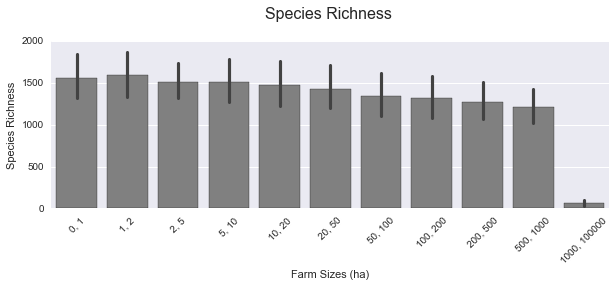

In [6]:
richness = pd.pivot_table(data_orig, 
                          index=['Farm_Sizes', 'NAME_0'],
                          values='Item_Code',
                          aggfunc=lambda x: len(x.unique()))
richness = richness.reset_index()
richness = richness.sort_values('Item_Code', ascending=False)

order = pd.pivot_table(data_orig, 
                          index=['Farm_Sizes'],
                          values='Item_Code',
                          aggfunc=lambda x: len(x.unique()))
order = order.reset_index()
order = order.sort_values('Farm_Sizes', ascending=True)

fs = order['Farm_Sizes'].unique()

fig = plt.figure(figsize=[10, 3])
ax = fig.add_subplot(111)
sns.barplot(richness['Farm_Sizes'].astype(str), 
            richness['Item_Code'], 
            color='grey', 
            order=list(order['Farm_Sizes']), 
            estimator=np.sum,
            ax=ax);
ax.set_xticklabels([x[1:-1] for x in fs], rotation=45);
ax.set_xlabel('Farm Sizes (ha)');
ax.set_ylabel('Species Richness');
ax.set_title('Species Richness \n', fontsize=16);

<a name="Simpsons_Diversity"></a>
<left><h3>Simpson's Diversity</h3></left><br>

The Simpson's Diversity Index is a way to measure the richness and abundance of species diversity. Here, we use Simpson's Index to understand which farm size groups have the most species diversity. The index is calculated first by dividing the number of organisms of a particular species (number of plants per crop) by the number of organisms total. Then the sum of this ratio is taken across all species and squared. Finally, the inverse is taken. The higher the score, the more diverse. One advantage with Simpson's Index is that it is not affected by low abundant crops. Hence, if one farm size class has high richness, but many of the crops are only grown on a few farms, then Simpson's Index is minimally effected. Note, because we do not have actual counts of the number of plants per species we use production (converted to kcal) as a proxy. 

\begin{equation*}
D = 1 - \sum_{i=1}^s p_i^2
\end{equation*}

Where,<br>
&nbsp;&nbsp;&nbsp;&nbsp; i = a particular farm size class<br>
&nbsp;&nbsp;&nbsp;&nbsp; n = the total number of organisims of a  particular species, and<br>
&nbsp;&nbsp;&nbsp;&nbsp; N = the total number of organisims of all species<br><br>
&nbsp;&nbsp;&nbsp;&nbsp; p = n/N

In [7]:
def diversity_indices(data, variable='production_kcal'):

    if variable is 'production_kcal':

        pivot = pd.pivot_table(data,
                               index=['Farm_Sizes', 'NAME_0', 'Item_Code_ix'],  # 'NAME_0',
                               values=variable,
                               aggfunc=np.nansum)
        
        pivot2 = pd.pivot_table(data,
                               index=['Farm_Sizes', 'NAME_0'],  # NAME_0
                               values=variable,
                               aggfunc=np.nansum)
        
    elif variable is 'Item_Code':
        
        pivot = pd.pivot_table(data,
                               index=['Farm_Sizes', 'NAME_0', 'Item_Code_ix'],  # NAME_0
                               values=variable,
                               aggfunc=np.count_nonzero)

        pivot2 = pd.pivot_table(data,
                               index=['Farm_Sizes', 'NAME_0'], # NAME_0
                               values=variable,
                               aggfunc=np.count_nonzero)

    pivot = pivot.reset_index()
    pivot2 = pivot2.reset_index()
    pivot = pd.merge(pivot, pivot2, on=['Farm_Sizes', 'NAME_0'], how='outer')  # NAME_0
    pivot = pivot.reset_index()
    pivot['p'] = pivot[variable + '_x'] / pivot[variable + '_y']
    
    H = -1 * np.nansum(pivot['p'] * np.log(pivot['p']))
    D = 1 - (np.nansum(pivot['p']**2))
        
    return D, H

def diversity_entire(data, variable='production_kcal', metric='simpsons'):

    farms = []
    names = []
    ds = []

    for farm in data.loc[~data['Farm_Sizes'].isnull()]['Farm_Sizes'].unique():

        tmp = data.loc[data['Farm_Sizes'] == farm]

        for name in tmp['NAME_0'].unique():

            tmp2 = tmp.loc[tmp['NAME_0'] == name]

            d, h = diversity_indices(tmp2, variable=variable)

            farms.append(farm)
            names.append(name)
            
            if metric is 'simpsons':
                ds.append(d)

            elif metric is 'shannons':
                ds.append(h)
                
    out = pd.concat([pd.DataFrame(farms, columns=['Farm_Sizes']),
                     pd.DataFrame(names, columns=['NAME_0']),
                     pd.DataFrame(ds, columns=['ds'])],
                    axis=1)

    return out

def plot_diversity(data, title1="Species Diversity \n Simpson's Index"):

    fs_order = list(data_orig.sort_values('Farm_Sizes')['Farm_Sizes'].unique())[1:]

    fig = plt.figure(figsize=[15, 5])
    ax = fig.add_subplot(111)

    sns.barplot(x='Farm_Sizes', 
                y='ds',
                data=data,
                color='grey', 
                order=fs_order, 
                ax=ax);
    ax.set_xticklabels([x[1:-1] for x in fs_order], rotation=45);
    ax.set_xlabel('Farm Sizes (ha)');
    ax.set_ylabel('Species Diversity');
    ax.set_title(title1, fontsize=16);

    fig.tight_layout()
    
    return plt.show()

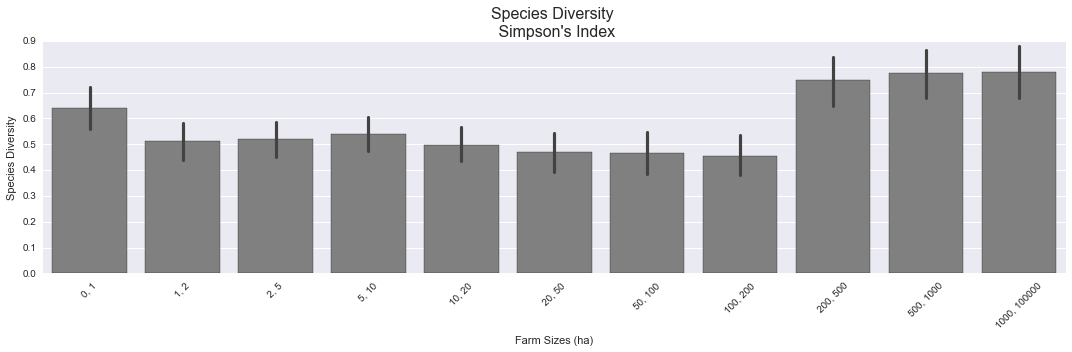

In [8]:
d_prod = diversity_entire(data_orig, variable='production_kcal', metric='simpsons')
plot_diversity(d_prod)

Visually, there apears to be significant differences between the largest three farm size classes and the remaining classes except for the smallest farm size class.

<a name="Shannons_Diversity"></a>
<left><h3>Shannon's Diversity</h3></left><br>

Since Simpson's Index tends to give more weight to dominant species, we will also calulate diversity with Shannon's Diversity Index. Shannon's Index is more affected by species richness than Simpson's Index and hence will indicate if a certain farm size class may have more overall crop diversity.

\begin{equation*}
H = \ -\sum_{i=1}^s \ p_i \ ln \ p_i
\end{equation*}

Where,<br>
&nbsp;&nbsp;&nbsp;&nbsp; i = crop<br>
&nbsp;&nbsp;&nbsp;&nbsp; s = number of species<br>
&nbsp;&nbsp;&nbsp;&nbsp; p = proportion of individuals (n) divided by the total number of individuals (N)<br>
&nbsp;&nbsp;&nbsp;&nbsp; s = number of species<br><br>

We use the same modification as for the Simpson's index to weight the results by production.


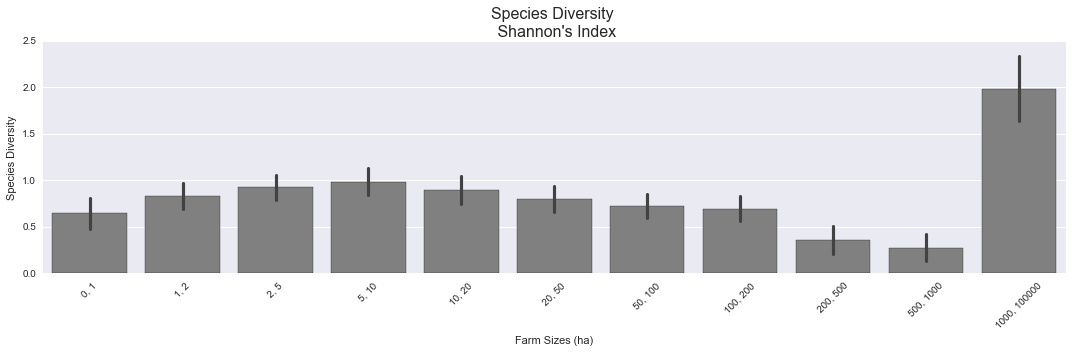

In [9]:
h_prod = diversity_entire(data_orig, variable='production_kcal', metric='shannons')
plot_diversity(h_prod, title1="Species Diversity \n Shannon's Index")

The largest farm size class has more diversity than the other classes, while the second and third largest have the lowest crop diversity. These results are very different than the Simpson's Index, which may indicate that there are different crops being grown in the largest farm size class. Note, the largest farm size class should be interpretted with caution, since this class has farm fewer observations that may have led to a very low richness score; species richness affects both diversity indices.

<a name="Evenness"></a>
<left><h3>Evenness</h3></left><br>

To further investigate the large differences between the Simpson and Shannon's indices we will first look at the distribution of crop prevelance in each farm size group. The assumption is that since the Simpson's Index minimizes crops that are not prevelent, the distribution (i.e., species evenness) of crops may explain the difference between the two diversity indices. While the richness metric counts how many crop species each farm size produces, evenness is the abundance (or distribution) of those species. Evenness can be calculated from the Shannon's Diversity index by dividing H by the natural log of species richness.

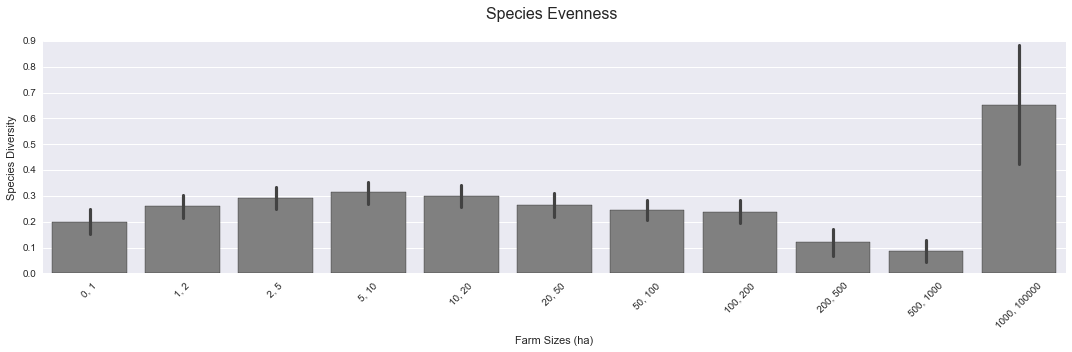

In [10]:
richness.columns = ['Farm_Sizes', 'NAME_0', 'Richness']
merged = pd.merge(richness, h_prod, on=['Farm_Sizes', 'NAME_0'], how='outer')
merged['ds'] = merged['ds'] / np.log(merged['Richness'])

plot_diversity(merged, title1="Species Evenness \n")

For the reasons stated above, for now we will ignore the largest farm size class. The evenness results may explain why the smallest farm size and the second and third largest farm size classes received large Simpson but small Shannon indices. These classes may have more diversity of common species (Simpsons Index), but less diversity of total species (Shannons Index). In other words, these identified farm sizes may be producing different species from the rest of the farm sizes.

<a name="Sorensons_Coefficient"></a>
<left><h3>Sorenson's Coefficient</h3></left><br>

To test whether the crop composition is different between farm size classes, we will use the Sorenson's Coefficient (CC). Sorenson's Coefficient is a ratio of the number of overlapping species between two communities (farm size classes) and the total number of species across two communities.

\begin{equation*}
CC_{i,j} = \frac{2C_{i,j}}{S_i + S_j}
\end{equation*}

Where,<br>
C = the number of species the two classes have in common<br>
S = the total number of species found in the given farm size class<br>
i = farm size class 1<br>
j = farm size class 2<br><br>

Note: This calculation will be done for each i,j combination (i.e., all combinations of farm sizes will be compared)

In [11]:
tmp = data_orig.copy()
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].astype(str)

sorensons = pd.pivot_table(tmp, 
                           index=['NAME_0', 'Item_Code_ix'],
                           values='Item_Code',
                           columns='Farm_Sizes',
                           aggfunc=lambda x: float(len(x.unique())))
sorensons = sorensons.iloc[:, : -1]

cols = sorensons.columns
combos = list(itertools.combinations(cols, 2))
Sn = pd.pivot_table(sorensons.reset_index(), index='NAME_0', aggfunc=np.nansum).iloc[:, :-1]

for i in xrange(len(combos)):
    sorensons['C_' + combos[i][0] + '_' + combos[i][1]] = np.where(((sorensons[combos[i][0]] > 0. ) &
                                                                     (sorensons[combos[i][1]] > 0. )), 1.0, np.nan)
    Sn['Sn_' +  combos[i][0] + '_' + combos[i][1]] = Sn[combos[i][0]] + Sn[combos[i][1]]

Sn = Sn.filter(regex='Sn_.*')
C = sorensons.filter(regex=('C_.*'))
C = pd.pivot_table(C.reset_index(), index='NAME_0', aggfunc=np.nansum).iloc[:, :-1]
CC = pd.DataFrame(2 * C.as_matrix() / Sn.as_matrix(), columns=C.columns, index=C.index).head()

In [19]:
t = CC.copy()
t = t.transpose().reset_index()
combos = t['Farm_Sizes'].str.split('_', expand=True)
combos.columns = ['C', 'Combo1', 'Combo2']

t = pd.concat([t, combos], axis=1)

for col in list(combos.columns[1:]):
    t[col] = t[col].str.replace('(', '')
    t[col] = t[col].str.replace(']', '')
    
t = t.sort_values(['Combo1', 'Combo2'])
t = t.set_index(['Combo1', 'Combo2'])
t = t.drop(['Farm_Sizes', 'C'], 1)
t = pd.DataFrame(t.mean(axis=1), columns=['CC']).reset_index()
tr = t.loc[:, ['Combo2', 'Combo1', 'CC']]
tr.columns = t.columns
t = pd.concat([t, tr], axis=0)
fs_order = [u'0, 1', u'1, 2', u'2, 5', u'5, 10', u'10, 20', 
            u'20, 50', u'50, 100', u'100, 200', u'200, 500', 
            u'500, 1000', u'1000, 100000']

sorterIndex = dict(zip(fs_order,range(len(fs_order))))
t['Combo1_ix'] = t['Combo1'].map(sorterIndex)
t['Combo2_ix'] = t['Combo2'].map(sorterIndex)
t = t.sort_values(['Combo1_ix', 'Combo2_ix'])
t = t.iloc[:, 2:]
t = t.set_index(['Combo1_ix', 'Combo2_ix'])
t = pd.DataFrame(t.unstack())

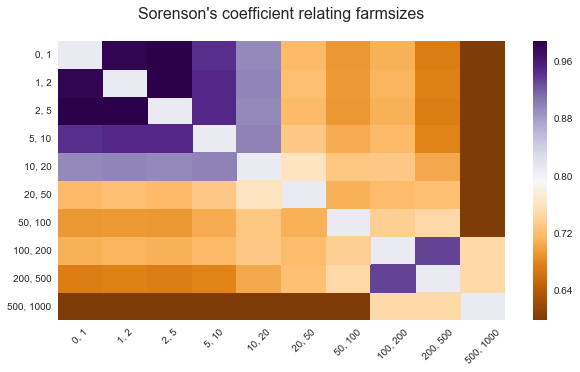

In [30]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
sns.heatmap(t.iloc[:-1,:-1], cmap='PuOr' , ax=ax);
ax.set_xlabel('');
ax.set_ylabel('');
fs_order_n = fs_order[:-1]
ax.set_xticklabels(fs_order_n, rotation=45);
ax.set_yticklabels(fs_order_n[::-1], rotation=0);
ax.set_title("Sorenson's coefficient relating farmsizes\n", fontsize=16);

The Sorenson's coefficient is plotted above. Higher (dark purple) values represent greater overlap in the crops the given farm size class pair produce, while darker brown values represent low overlap. For example, the 0 to 1 ha and 1 to 2 ha classes produce a large amount of the same crops, while the 0 to 1 ha and 500 to 1000 ha produce dissimilar crops.

<a name="Dietary_Impacts"></a>
<left><h3>Dietary Impacts</h3></left><br>

Finally, we will look at the fat and protein content (and other micronutrients if possible?) of the crops each farm size class grows. Since the smaller farmsize classes showed greater similarity to one another in crops grown, and disimilarity with larger farms, we want to know if the food produced on smaller farms is providing a different set of nutrients. 

Due to data limitations, we were only able to calculate kcal, fat, and protein for each crop grown. The conversion factors used were from the FAO food balance sheets.

Here we show the average kcal, fat, and protein per crop per farm size group. Note, we first seperated the data by the amount of food each farm size produced, then calculated the amount of kcal, fat, and protein in the available food as explained in the [General Results Notebook](https://vinnyricciardi.github.io/farmsize_site/Html/General_Results).

In [164]:
nutrients = data_orig.loc[:, ['Farm_Sizes', 
#                               'production_Food_kcal', 
                              'production_Food_fat', 
                              'production_Food_protein']]


grouped = nutrients.groupby('Farm_Sizes').agg(np.nansum)
grouped['total'] = grouped.sum(axis=1)

for col in grouped.columns:
    grouped[col] = grouped[col] / grouped['total']

grouped = grouped.iloc[:, : -1]

In [117]:
nutrients = data_orig.loc[:, ['Farm_Sizes',
                              'NAME_0',
                              'production_Food_kcal', 
                              'production_Food_fat', 
                              'production_Food_protein']]

grouped = nutrients.groupby(['Farm_Sizes', 'NAME_0']).agg(np.nansum)
grouped = grouped.iloc[:, :].reset_index()
grouped = grouped.loc[(grouped['production_Food_kcal'] > 0.0) &
                     (grouped['production_Food_fat'] > 0.0) &
                     (grouped['production_Food_protein'] > 0.0)]

for col in grouped.columns[2:]:
    grouped[col] = np.log(grouped[col])
    
# grouped = pd.melt(grouped, id_vars=['Farm_Sizes'])
# grouped.head()
# grouped = grouped.loc[grouped['value'] > 0.0]
# grouped['value'] = np.log(grouped['value'])
# grouped = grouped.sort_values(['variable', 'value'])

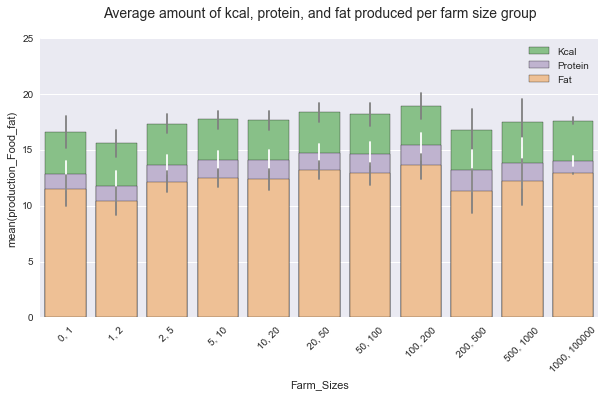

In [163]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)

from collections import OrderedDict
import matplotlib as mpl
plots = OrderedDict([('production_Food_kcal', ['Kcal', '#7fc97f', 'grey']),
                     ('production_Food_protein', ['Protein', '#beaed4', 'white']),
                     ('production_Food_fat', ['Fat', '#fdc086', 'grey'])])

with mpl.rc_context({"lines.linewidth": 1}):
    colors = ["black", "grey", "white"]
    
    for key, value in plots.iteritems():

        g = sns.barplot(x='Farm_Sizes', 
                        y=key, 
                        data=grouped, 
                        label=value[0], 
                        color=value[1],
                        errcolor=value[2],
                        ax=ax)
        
    
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [x[1:-1] for x in labels]
ax.set_xticklabels(labels, rotation=45)
ax.set_title('Average amount of kcal, protein, and fat produced per farm size group\n',
            fontsize=14)

legend = ax.legend(frameon=True, fontsize=12)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1],
                   loc='center left',
                   frameon=1,
                   bbox_to_anchor=(1, 0.5))
frame = legend.get_frame()
frame.set_color('#ffffff')

ax.legend();